<a href="https://colab.research.google.com/github/RedLynx96/Estimation_of_safety_functions/blob/main/Predictor_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#VERIFY THAT COLAB IS USING THE GPU, GO TO Runtime > Change runtime type.
# Code was trained on tensorflow 2.10. The current notebook works on tensorflow 2.17.1

!git clone https://github.com/RedLynx96/Estimation_of_safety_functions

Cloning into 'Estimation_of_safety_functions'...
Updating files:  62% (30/48)
Updating files:  64% (31/48)
Updating files:  66% (32/48)
Updating files:  68% (33/48)
Updating files:  70% (34/48)
Updating files:  72% (35/48)
Updating files:  75% (36/48)
Updating files:  77% (37/48)
Updating files:  79% (38/48)
Updating files:  81% (39/48)
Updating files:  83% (40/48)
Updating files:  85% (41/48)
Updating files:  87% (42/48)
Updating files:  89% (43/48)
Updating files:  91% (44/48)
Updating files:  93% (45/48)
Updating files:  95% (46/48)
Updating files:  97% (47/48)
Updating files: 100% (48/48)
Updating files: 100% (48/48), done.


In [21]:
# WARNING: DO NOT ESTIMATE THE CLASSICAL SAFETY FUNCTION OF THE LORENZ IN HERE, IT NEED TO BE DONE IN THE MATLAB FILE TO ACCOUNT 
# FOR VARIABLE NOISE

In [22]:
!apt-get update -qq
!apt-get install -y --no-install-recommends graphviz
!pip install --upgrade pip
#!pip install --upgrade --force-reinstall tensorflow==2.10.0

import sys
sys.path.append('/content/Estimation_of_safety_functions/')
from lib import Helper_FCN as HFCN

"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/85/8a/1ddf40be20103bcc605db840e9ade09c8e8c9f920a03e9cfe88eae97a058/pip-25.0-py3-none-any.whl.metadata
  Using cached pip-25.0-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\A.Fisica\anaconda3\python.exe -m pip install --upgrade pip


In [23]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import scipy.io as sp

In [24]:
def get_best_strategy():
    """
    Determines the best TensorFlow distribution strategy available.

    Tries to initialize a TPU strategy. If TPU is not available, it checks for GPUs
    and uses MirroredStrategy. If neither TPU nor GPU is available, it defaults to the CPU.

    Returns:
        tf.distribute.Strategy: The best available distribution strategy.
    """
    # 1) Try to connect to TPU
    try:
        # Initialize TPUClusterResolver
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        print("TPU detected and connecting...")

        # Connect to the TPU cluster
        tf.config.experimental_connect_to_cluster(resolver)

        # Initialize the TPU system
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("TPU system initialized.")

        # Create TPUStrategy
        strategy = tf.distribute.TPUStrategy(resolver)
        print("Using TPU strategy.")
        return strategy
    except (ValueError, tf.errors.NotFoundError) as e:
        print("No TPU found or not available. Error:", e)

    # 2) If no TPU, check for GPUs
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Create MirroredStrategy for GPUs
            strategy = tf.distribute.MirroredStrategy()
            print(f"GPU(s) found: {gpus}. Using MirroredStrategy with GPU(s).")
            return strategy
        except Exception as e:
            print("Error initializing MirroredStrategy for GPUs:", e)

    # 3) If no TPU and no GPU, fallback to CPU
    strategy = tf.distribute.get_strategy()
    print("No TPU or GPU found. Falling back to default strategy (CPU).")
    return strategy

# Use the function
strategy = get_best_strategy()

print("Strategy in use:", strategy)
print("Logical devices:", tf.config.list_logical_devices())


No TPU found or not available. Error: Please provide a TPU Name to connect to.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
GPU(s) found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]. Using MirroredStrategy with GPU(s).
Strategy in use: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x00000254467880D0>
Logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


In [25]:
# Define the CustomMultiHeadAttention class without overriding build()
class CustomMultiHeadAttention(layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        # Remove conflicting arguments if present
        for arg_to_remove in ["query_shape", "key_shape", "value_shape"]:
            if arg_to_remove in kwargs:
                del kwargs[arg_to_remove]
        super().__init__(**kwargs)

    # Removed the build method to prevent passing unexpected arguments

###############################################################################
# 1) Define a function to build the model
###############################################################################
def build_model(mean_extension):
    """
    Constructs the model architecture based on the mean_extension.
    """
    input_1 = layers.Input(shape=(mean_extension, 2), name='input_1')
    input_2 = layers.Input(shape=(1,), name='input_2')

    repeated_input_2 = layers.RepeatVector(mean_extension)(input_2)
    x_input = layers.concatenate([input_1, repeated_input_2], axis=-1)

    # Block 1
    x = CustomMultiHeadAttention(key_dim=256, num_heads=4, dropout=0.05)(x_input, x_input)
    res = layers.Add()([x, x_input])

    x = layers.Conv1D(filters=1024, kernel_size=1, activation="relu")(res)
    x = layers.Conv1D(filters=x_input.shape[-1], kernel_size=1)(x)
    xn = layers.Add()([x, res])

    # Block 2
    x = CustomMultiHeadAttention(key_dim=256, num_heads=4, dropout=0.05)(xn, xn)
    res = layers.Add()([x, xn])

    x = layers.Conv1D(filters=1024, kernel_size=1, activation="relu")(res)
    x = layers.Conv1D(filters=x_input.shape[-1], kernel_size=1)(x)
    xn = layers.Add()([x, res])

    # Block 3
    x = layers.Conv1D(filters=512, kernel_size=7, activation="relu")(xn)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # Block 4
    x_max = layers.GlobalMaxPooling1D()(x)
    x_avg = layers.GlobalAveragePooling1D()(x)
    x = layers.concatenate([x_max, x_avg])

    # Block 5 (output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='linear', name='output')(x)

    # Create the model
    model = Model(inputs=[input_1, input_2], outputs=x, name=f"{mean_extension}_input_model")

    # Compile the model with a generic loss (only necessary if training or evaluating)
    model.compile(optimizer=Adam(learning_rate=0.00015), loss='mse')

    return model

###############################################################################
# 2) Select and load multiple models
###############################################################################
models_dir = "/content/Estimation_of_safety_functions/pretrained_models"

models_dir = "pretrained_models/"

available_models = sorted([
    d for d in os.listdir(models_dir)
    if os.path.isdir(os.path.join(models_dir, d))
])

print("Available models in pretrained_models:")
for i, model_name in enumerate(available_models, start=1):
    print(f"{i}. {model_name}")

# Allow multiple selections, e.g., "1,3,5"
choice_str = input("\nEnter the numbers of the models you want to load (comma-separated): ").strip()
# Example input: "1,3,5"

# Parse the input: convert to list of indices
try:
    choice_indices = [int(x.strip()) - 1 for x in choice_str.split(",")]
except ValueError:
    raise ValueError("Invalid input. Please enter valid numbers separated by commas.")

###############################################################################
# 3) Load each model and its weights
###############################################################################
models = {}  # Dictionary to store loaded models

with strategy.scope():
    for idx in choice_indices:
        if idx < 0 or idx >= len(available_models):
            print(f"Skipping invalid choice index: {idx+1}")
            continue
        chosen_model_dir = available_models[idx]
        print(f"\nYou selected model: {chosen_model_dir}")

        # Determine mean_extension based on directory name
        try:
            mean_extension = int(chosen_model_dir)
        except ValueError:
            print(f"Model directory name '{chosen_model_dir}' is not an integer. Skipping.")
            continue  # Or assign a default value if preferred

        # Define the model architecture
        model = build_model(mean_extension)
        print(f"Model architecture for mean_extension={mean_extension} defined.")

        # Construct the path to the weights
        # Ensure that the weights file is named "{chosen_model_dir}_chk.hdf5"
        weights_name = f"{chosen_model_dir}_chk.hdf5"
        weights_path = os.path.join(models_dir, chosen_model_dir, weights_name)

        # Verify if the weights file exists
        if not os.path.exists(weights_path):
            print(f"Warning: Weights file not found: {weights_path}. Skipping this model.")
            continue  # Or raise an error if preferred

        # Load the weights
        try:
            model.load_weights(weights_path)
            print(f"Weights loaded for model: {chosen_model_dir}")
        except Exception as e:
            print(f"Error loading weights for model {chosen_model_dir}: {e}")
            continue

        # Add the model to the dictionary
        models[chosen_model_dir] = model

print("\nAll selected models have been loaded.\n")


Available models in pretrained_models:
1. 100
2. 1000
3. 2000
4. 25
5. 250
6. 50
7. 500

You selected model: 2000
Model architecture for mean_extension=2000 defined.
Weights loaded for model: 2000

All selected models have been loaded.



In [26]:
mat_dir = "/content/Estimation_of_safety_functions/mat_examples"

mat_dir = "mat_examples/"

mat_files = [f for f in os.listdir(mat_dir) if f.endswith(".mat")]

print("These .mat files are found in mat_examples:")
for i, file_name in enumerate(mat_files, start=1):
    print(f"{i}. {file_name}")

choice_mat = input("\nEnter the number of the .mat file you want to load: ")
try:
    mat_idx = int(choice_mat) - 1
    if mat_idx < 0 or mat_idx >= len(mat_files):
        raise IndexError
    mat_file_name = mat_files[mat_idx]
except (ValueError, IndexError):
    raise ValueError("Invalid choice for .mat file.")

mat_file = os.path.join(mat_dir, mat_file_name)
print(f"\nLoading .mat file from: {mat_file}")
mat_data = sp.loadmat(mat_file)

xVectors = mat_data["xVectors"]
xVectors = np.nan_to_num(xVectors, nan=-1)

try:
    xVectors = xVectors.reshape((1000 * 50, 2))
    xVectors = xVectors[~np.any(xVectors == -1, axis=1)]

    Separated_xVectors = []
    for i in range(len(xVectors) - 1):
        Separated_xVectors.append(xVectors[i])
        if xVectors[i][1] != xVectors[i + 1][0]:
            Separated_xVectors.append([-1, -1])
    Separated_xVectors.append(xVectors[-1])
    xVectors = np.array(Separated_xVectors)

    print("\nTransformed xVectors shape:", xVectors.shape)
except:
    print('xVectors didnt get transformed, shape:', xVectors.shape)

x_inputs = {}
for model_name, model_obj in models.items():

    required_length = int(model_name)

    if xVectors.shape[0] >= required_length:
        x_req = xVectors[:required_length, :]
    else:
        padding = np.full((required_length - xVectors.shape[0], 2), -1)
        x_req = np.vstack((xVectors, padding))

    x_req = np.expand_dims(x_req, axis=0)
    x_inputs[model_name] = x_req
    print(f"Prepared x_inputs for model '{model_name}' with shape {x_req.shape}")

These .mat files are found in mat_examples:
1. 1.mat
2. 2.mat
3. 3.mat
4. 4.mat
5. 5.mat
6. Lorenz001.mat
7. Lorenz01.mat
8. LorenzNoiseless.mat

Loading .mat file from: mat_examples/3.mat

Transformed xVectors shape: (3835, 2)
Prepared x_inputs for model '2000' with shape (1, 2000, 2)


32/32 [==============================] - 4s 64ms/step


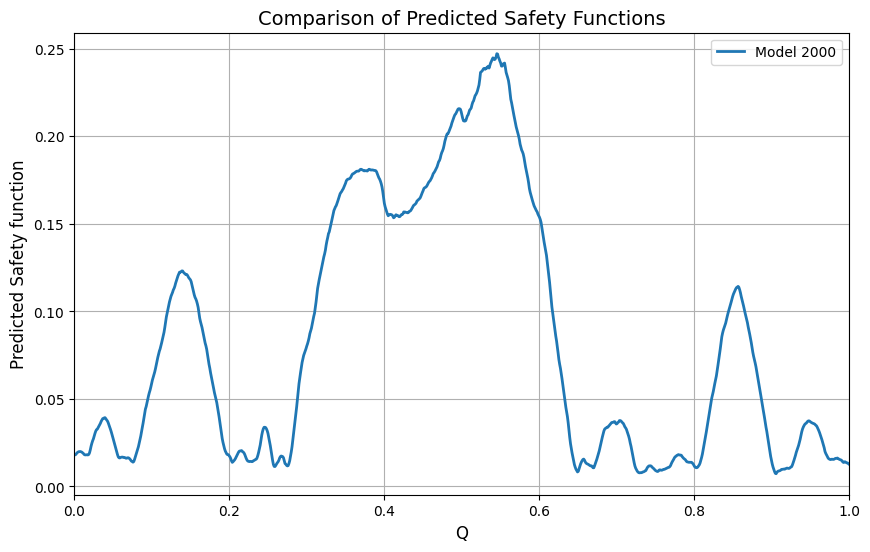

In [27]:
Ic = np.linspace(0, 1, 1000)
predictions = {}

for model_name, model_obj in models.items():
    required_length = int(model_name)

    if xVectors.shape[0] >= required_length:
        x_req = xVectors[:required_length, :]
    else:
        num_padding = required_length - xVectors.shape[0]
        padding = np.full((num_padding, 2), -1)
        x_req = np.vstack((xVectors, padding))

    x_req = np.expand_dims(x_req, axis=0)
    tiled_x_req = np.tile(x_req, (len(Ic), 1, 1))
    Ic_input = np.expand_dims(Ic, axis=-1)
    pred = model_obj.predict([tiled_x_req, Ic_input])
    predictions[model_name] = pred.squeeze()

plt.figure(figsize=(10, 6))

for model_name, pred in predictions.items():
    plt.plot(Ic, pred, label=f"Model {model_name}", linewidth=2)

plt.xlabel("Q", fontsize=12)
plt.ylabel("Predicted Safety function", fontsize=12)
plt.title("Comparison of Predicted Safety Functions", fontsize=14)
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.show()


Maximum noise value: 1e-06
Converged in iteration: 13


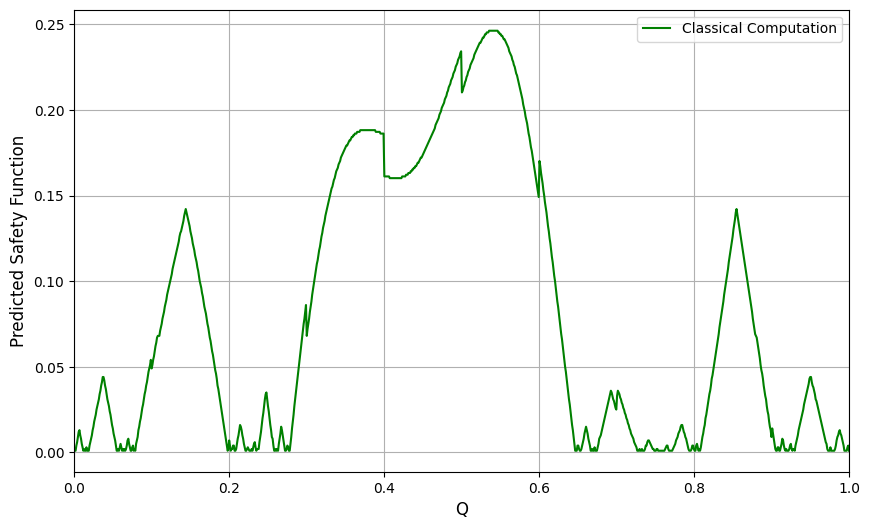

In [28]:
from scipy.interpolate import interp1d

# Classical computation of the safety function, here your file MUST have the map function f(x) defined as 'y', which should be an array shaped (1,1000)
y = mat_data['y'].flatten()
y = y[:1000]

# Verify that xVectors and y are defined
if 'xVectors' not in globals() or 'y' not in globals():
    raise ValueError("The variables 'xVectors' and 'y' are not defined. Please load the .mat file first.")

# Define the vector Ic
Ic = np.linspace(0, 1, 1000)

def GetNoise(xVectors, y, Ic):
    """
    Calculates the maximum noise based on xVectors and the known function y over Ic.

    Parameters:
    - xVectors (np.ndarray): Array of shape (N, 2) with non-noisy and noisy data.
    - y (np.ndarray): 1D array with values of the known function over Ic.
    - Ic (np.ndarray): 1D array with Q values.

    Returns:
    - float: The maximum noise value found.
    """
    # Create an interpolation function for y over Ic
    interp_func = interp1d(Ic, y, kind='linear', bounds_error=False, fill_value='extrapolate')

    # Filter out invalid samples where both columns are -1
    valid_mask = ~((xVectors[:, 0] == -1) & (xVectors[:, 1] == -1))
    valid_x = xVectors[valid_mask, 0]
    valid_noisy_y = xVectors[valid_mask, 1]

    # Interpolate y at the valid_x positions
    interpolated_y = interp_func(valid_x)

    # Calculate the absolute noise
    noise = np.abs(valid_noisy_y - interpolated_y)

    # Find the maximum noise
    max_noise = np.max(noise) + 1e-14  # Add a small value to avoid zero noise

    return max_noise

# Calculate noise_max
#noise_max = GetNoise(xVectors, y, Ic)
noise_max = 0.000001
print(f"Maximum noise value: {noise_max}")

# Define number of iterations
iterations = 25
NQ = len(Ic)
Q = Ic

# Interpolate y over Q
interp_func = interp1d(Q, y, kind='linear', fill_value='extrapolate', bounds_error=False)
Imagen = interp_func(Q).flatten()

# Define scale
scale = 1 / (NQ - 1)

# Define noise
noise = np.arange(-noise_max, noise_max + scale, scale)
Nnoise = len(noise)
anchor_noise = Nnoise // 2

# Initialize Imagen_ruido
Imagen_ruido = np.zeros((NQ, Nnoise))
for i in range(NQ):
    for j in range(Nnoise):
        Imagen_ruido[i, j] = y[i] + noise[j]

# Define ymin and ymax
ymin = np.min(Imagen_ruido) - scale
ymax = np.max(Imagen_ruido) + scale

Imagen_noisey = np.arange(ymin, ymax + scale, scale)
Nimagen_noisey = len(Imagen_noisey)
controly = np.zeros(Nimagen_noisey)

# Initialize Us
Us = np.zeros((iterations + 1, NQ))
IndImagen = np.round((Imagen - ymin) / scale).astype(int)
kend = iterations

# Iterative computation
for k in range(iterations):
    for m in range(Nimagen_noisey):
        controly_possible_inQ = np.abs(Imagen_noisey[m] - Q)
        controly[m] = np.min(np.maximum(Us[k, :], controly_possible_inQ))

    for i in range(NQ):
        lower = IndImagen[i] - anchor_noise
        upper = IndImagen[i] + anchor_noise
        lower = max(lower, 0)
        upper = min(upper, Nimagen_noisey)
        Us[k + 1, i] = np.max(controly[lower:upper])

    if np.array_equal(Us[k + 1, :], Us[k, :]):
        kend = k
        print(f'Converged in iteration: {kend}')
        break

Us = Us[:kend + 1, :]
classical_prediction = Us[kend, :]

# Visualize the classical prediction
plt.figure(figsize=(10, 6))
plt.plot(Ic, classical_prediction, label='Classical Computation', color='green', linestyle='-', linewidth=1.5)
plt.xlabel("Q", fontsize=12)
plt.ylabel("Predicted Safety Function", fontsize=12)
plt.title("", fontsize=14)
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.show()


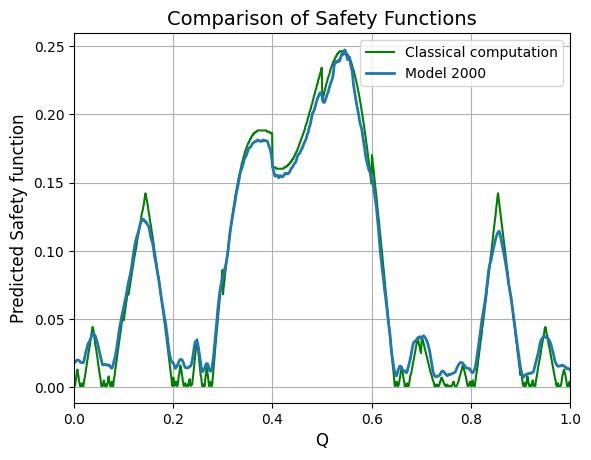

In [29]:
plt.plot(Ic, classical_prediction, label='Classical computation', color='green', linestyle='-', linewidth=1.5)

for model_name, pred in predictions.items():
    # Aseguramos len(pred) == len(Ic)
    plt.plot(Ic, pred, label=f"Model {model_name}", linewidth=2)

plt.xlabel("Q", fontsize=12)
plt.ylabel("Predicted Safety function", fontsize=12)
plt.title("Comparison of Safety Functions", fontsize=14)
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.show()
